# CoverType EDA

The [Covertype data set](https://archive.ics.uci.edu/ml/datasets/covertype) is a widely used dataset for benchmarking concept drift handling systems [ref](https://arxiv.org/pdf/1704.00023.pdf). The data set is formulated for the problem of predicting forest cover type from cartographic variables only (no remotely sensed data). The actual forest cover type for a given observation (30 x 30 meter cell) was determined from US Forest Service (USFS) Region 2 Resource Information System (RIS) data. Independent variables were derived from data originally obtained from US Geological Survey (USGS) and USFS data. Data is in raw form (not scaled) and contains binary (0 or 1) columns of data for qualitative independent variables (wilderness areas and soil types).

The study area includes four wilderness areas located in the Roosevelt National Forest of northern Colorado. These areas represent forests with minimal human-caused disturbances, so that existing forest cover types are more a result of ecological processes rather than forest management practices. As such, the drift that exists in this dataset is expected to be categorical in nature, rather than time-dependent.

In this notebook, we:
- explore the the data set
- realize that significant drift is not present across `wilderness_area`
- apply a method to induce drift

In [1]:
import os
import sys

sys.path.append(os.path.dirname(os.getcwd()))

import pickle
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder

%load_ext nb_black
%load_ext autoreload
%autoreload 2

<IPython.core.display.Javascript object>

## Load Data

In [2]:
# specify columns to keep and if categorical
col_names = [
    ("elevation", False),
    ("aspect", False),
    ("slope", False),
    ("horizontal_dist_to_hydrology", False),
    ("vertical_dist_to_hydrology", False),
    ("horizontal_dist_to_roadways", False),
    ("hillshade_9am", False),
    ("hillshade_noon", False),
    ("hillshade_3pm", False),
    ("horizontal_dist_to_fire_points", False),
]
wilderness_area_cols = [(f"wilderness_area_{i+1}", True) for i in range(4)]
soil_type_cols = [(f"soil_type_{i+1}", True) for i in range(40)]

col_names = col_names + wilderness_area_cols + soil_type_cols + [("cover_type", True)]

<IPython.core.display.Javascript object>

In [3]:
df = pd.read_csv(
    "../data/covtype.data", header=None, names=[col_name[0] for col_name in col_names]
)

<IPython.core.display.Javascript object>

In [4]:
df

,elevation,aspect,slope,horizontal_dist_to_hydrology,vertical_dist_to_hydrology,horizontal_dist_to_roadways,hillshade_9am,hillshade_noon,hillshade_3pm,horizontal_dist_to_fire_points,...,soil_type_32,soil_type_33,soil_type_34,soil_type_35,soil_type_36,soil_type_37,soil_type_38,soil_type_39,soil_type_40,cover_type
0,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,0,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581007,2396,153,20,85,17,108,240,237,118,837,...,0,0,0,0,0,0,0,0,0,3
581008,2391,152,19,67,12,95,240,237,119,845,...,0,0,0,0,0,0,0,0,0,3
581009,2386,159,17,60,7,90,236,241,130,854,...,0,0,0,0,0,0,0,0,0,3
581010,2384,170,15,60,5,90,230,245,143,864,...,0,0,0,0,0,0,0,0,0,3


<IPython.core.display.Javascript object>

In [5]:
58101

58101

<IPython.core.display.Javascript object>

## Preprocessing

By default this dataset poses a multiclass classification problem because the target variable `cover_type` takes on 7 different options. To simplify the problem here, we will only consider the two most populous classes and drop the rest of the data from consideration.


In [6]:
df.cover_type.value_counts()

2    283301
1    211840
3     35754
7     20510
6     17367
5      9493
4      2747
Name: cover_type, dtype: int64

<IPython.core.display.Javascript object>

In [7]:
# drop records where cover_type isn't 1 or 2
df = df[df.cover_type.isin([1, 2])].reset_index(drop=True)

# label encode categorical columns (this will only change the cover_type column)
catcols = (col for col, iscat in col_names if iscat)

for col in catcols:
    df[col] = LabelEncoder().fit_transform(df[col])

# convert to categorical
def categorize(df, cols):
    catcols = (col for col, iscat in cols if iscat)
    for col in catcols:
        df[col] = pd.Categorical(df[col])
    return df


df = categorize(df, col_names)

<IPython.core.display.Javascript object>

In [8]:
df.dtypes

elevation                            int64
aspect                               int64
slope                                int64
horizontal_dist_to_hydrology         int64
vertical_dist_to_hydrology           int64
horizontal_dist_to_roadways          int64
hillshade_9am                        int64
hillshade_noon                       int64
hillshade_3pm                        int64
horizontal_dist_to_fire_points       int64
wilderness_area_1                 category
wilderness_area_2                 category
wilderness_area_3                 category
wilderness_area_4                 category
soil_type_1                       category
soil_type_2                       category
soil_type_3                       category
soil_type_4                       category
soil_type_5                       category
soil_type_6                       category
soil_type_7                       category
soil_type_8                       category
soil_type_9                       category
soil_type_1

<IPython.core.display.Javascript object>

## Induce Controlled Data Drift

### a. Use `wilderness_area` as a proxy for distribution change

In [9]:
df[[col for col, _ in wilderness_area_cols]].value_counts()

wilderness_area_1  wilderness_area_2  wilderness_area_3  wilderness_area_4
1                  0                  0                  0                    251914
0                  0                  1                  0                    212621
                   1                  0                  0                     27580
                   0                  0                  1                      3026
dtype: int64

<IPython.core.display.Javascript object>

- Wilderness area's are overlapping (aka non sequential), we might need to bunch these as a way to impose "artifical data drift"
- Also, they are not equally distributed


Let's reorder all records by this area.

In [10]:
# # order dataset by wilderness area
# df = pd.concat(
#     [df[df[f"wilderness_area_{i}"] == 1].reset_index(drop=True) for i in (1, 3, 2, 4)]
# ).reset_index(drop=True)


<IPython.core.display.Javascript object>

In [11]:
# df[df.wilderness_area_1==1]
# df[df.wilderness_area_3==1]
# df[df.wilderness_area_2==1]
# df[df.wilderness_area_4==1]

<IPython.core.display.Javascript object>

**This doesn't introduce controlled enough drift**

### b. Induce drift by changing features

In similar fashion as authors of [MD3 paper](https://arxiv.org/pdf/1704.00023.pdf), we can introduce drift in a controlled manner while retaining properties of the real world data by systematically swapping features.

Process:
1. Shuffle all data to remove unwanted concept drift
2. Figure out which features are most/least important to classification (will be used in Step 4)
3. Separate dataset by specified changepoints into chunks to represent differing concepts + In each chunk, select 25% of features (based on highest/lowest feature importance) per class and rotate them to induce drift. Features of high importance should impose "real drift", while lowest importance features should impose "virtual drift"

### 1. Shuffle all records and normalize

In [12]:
df = df.sample(frac=1, random_state=42)

<IPython.core.display.Javascript object>

In [13]:
from sklearn.preprocessing import MinMaxScaler

<IPython.core.display.Javascript object>

In [14]:
df.head()

,elevation,aspect,slope,horizontal_dist_to_hydrology,vertical_dist_to_hydrology,horizontal_dist_to_roadways,hillshade_9am,hillshade_noon,hillshade_3pm,horizontal_dist_to_fire_points,...,soil_type_32,soil_type_33,soil_type_34,soil_type_35,soil_type_36,soil_type_37,soil_type_38,soil_type_39,soil_type_40,cover_type
426349,2836,343,15,190,3,700,188,216,166,1181,...,0,1,0,0,0,0,0,0,0,1
81549,2939,174,14,182,27,4590,227,246,148,2665,...,0,0,0,0,0,0,0,0,0,1
429494,3181,46,28,582,15,812,216,168,71,1681,...,0,1,0,0,0,0,0,0,0,0
321330,3233,123,12,661,29,3030,240,231,120,3024,...,1,0,0,0,0,0,0,0,0,1
183784,3023,24,8,531,43,1207,216,222,143,2347,...,0,0,0,0,0,0,0,0,0,1


<IPython.core.display.Javascript object>

In [15]:
norm_df = pd.DataFrame(
    MinMaxScaler().fit_transform(df), index=df.index, columns=df.columns
)

<IPython.core.display.Javascript object>

In [16]:
df = norm_df.copy()

<IPython.core.display.Javascript object>

### 2. Find most/least important features

In [17]:
%%time

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier

X = df.iloc[:, :-1]
y = df.iloc[:, -1]

def fit_gscv(X, y):

    model = RandomForestClassifier(n_estimators=10, random_state=42, max_depth=5)
    param_grid = {"clf__n_estimators": [5, 10, 20], "clf__max_depth": [5, 10, 20]}

    pipe = Pipeline(
        steps=[
            ("scaler", MinMaxScaler()),
            ("clf", model),
        ]
    )

    gs = GridSearchCV(
        estimator=pipe,
        param_grid=param_grid,
        cv=5,
        scoring='accuracy',
        n_jobs=-1,
        refit=True,
        return_train_score=True,
    )

    gs.fit(X, y)
    
    return gs


CPU times: user 60.1 ms, sys: 23.4 ms, total: 83.5 ms
Wall time: 110 ms


<IPython.core.display.Javascript object>

In [18]:
gs = fit_gscv(X, y)

print(
    f"""Best Params: {gs.best_params_} \n
        Best Train Score: {gs.cv_results_["mean_train_score"][gs.best_index_]} \n
        Best Test Score: {gs.best_score_}"""
)

Best Params: {'clf__max_depth': 20, 'clf__n_estimators': 20} 

        Best Train Score: 0.9400428377306911 

        Best Test Score: 0.9128571417517698


<IPython.core.display.Javascript object>

<AxesSubplot:ylabel='features'>

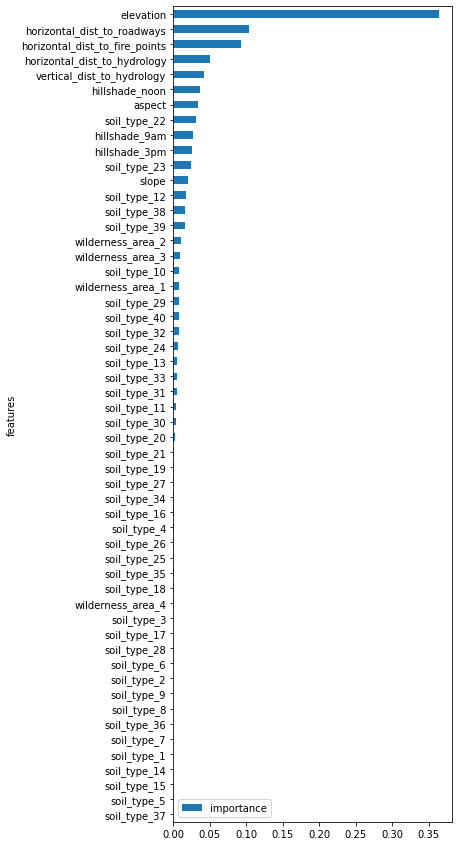

<IPython.core.display.Javascript object>

In [19]:
# plot global feature importances
importance_scores = gs.best_estimator_.named_steps["clf"].feature_importances_.tolist()
feature_names = X.columns.tolist()

pd.DataFrame(
    zip(feature_names, importance_scores), columns=["features", "importance"]
).set_index("features").sort_values("importance").plot(kind="barh", figsize=(5, 15))

**Because the soil types are not very useful to the model, lets disregard them all to simplify the problem**

In [20]:
df = df.drop(columns=[st for st, iscat in soil_type_cols if iscat])

X = df.iloc[:, :-1]
y = df.iloc[:, -1]

gs = fit_gscv(X, y)

print(
    f"""Best Params: {gs.best_params_} \n
        Best Train Score: {gs.cv_results_["mean_train_score"][gs.best_index_]} \n
        Best Test Score: {gs.best_score_}"""
)

Best Params: {'clf__max_depth': 20, 'clf__n_estimators': 20} 

        Best Train Score: 0.982328266112787 

        Best Test Score: 0.9410289204047213


<IPython.core.display.Javascript object>

<AxesSubplot:ylabel='features'>

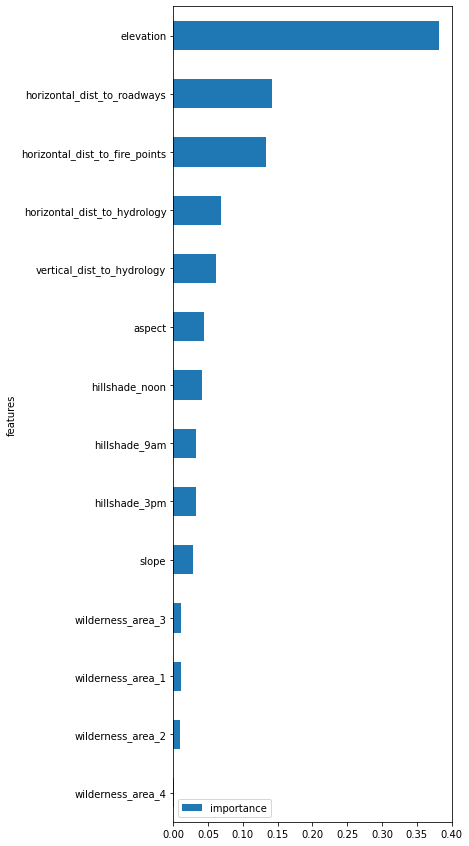

<IPython.core.display.Javascript object>

In [21]:
# plot global feature importances
importance_scores = gs.best_estimator_.named_steps["clf"].feature_importances_.tolist()
feature_names = X.columns.tolist()

pd.DataFrame(
    zip(feature_names, importance_scores), columns=["features", "importance"]
).set_index("features").sort_values("importance").plot(kind="barh", figsize=(5, 15))

In [22]:
# sort features by importance and get ranked names
ranked_features = sorted(
    zip(feature_names, importance_scores), key=lambda x: x[1], reverse=True
)
ranked_features = [feat[0] for feat in ranked_features]

<IPython.core.display.Javascript object>

In [25]:
ranked_features

['elevation',
 'horizontal_dist_to_roadways',
 'horizontal_dist_to_fire_points',
 'horizontal_dist_to_hydrology',
 'vertical_dist_to_hydrology',
 'aspect',
 'hillshade_noon',
 'hillshade_9am',
 'hillshade_3pm',
 'slope',
 'wilderness_area_3',
 'wilderness_area_1',
 'wilderness_area_2',
 'wilderness_area_4']

<IPython.core.display.Javascript object>

In [24]:
# save out a copy of the "undrifted" full dataset
# with open("../data/covtype_nodrift_norm.pkl", "wb") as f:
#     pickle.dump(df, f)

<IPython.core.display.Javascript object>

### INSPECT - are our features normally distributed?

In [34]:
import matplotlib.pyplot as plt

<IPython.core.display.Javascript object>

In [35]:
df = df.reset_index(drop=True)

<IPython.core.display.Javascript object>

In [36]:
df.head()

,elevation,aspect,slope,horizontal_dist_to_hydrology,vertical_dist_to_hydrology,horizontal_dist_to_roadways,hillshade_9am,hillshade_noon,hillshade_3pm,horizontal_dist_to_fire_points,wilderness_area_1,wilderness_area_2,wilderness_area_3,wilderness_area_4,cover_type
0,0.449482,0.952778,0.227273,0.136006,0.227390,0.098356,0.740157,0.850394,0.653543,0.164645,0.0,0.0,1.0,0.0,1.0
1,0.516192,0.483333,0.212121,0.130279,0.258398,0.644935,0.893701,0.968504,0.582677,0.371532,1.0,0.0,0.0,0.0,1.0
2,0.672927,0.127778,0.424242,0.416607,0.242894,0.114093,0.850394,0.661417,0.279528,0.234351,0.0,1.0,0.0,0.0,0.0
3,0.706606,0.341667,0.181818,0.473157,0.260982,0.425741,0.944882,0.909449,0.472441,0.421581,0.0,0.0,1.0,0.0,1.0
4,0.570596,0.066667,0.121212,0.380100,0.279070,0.169594,0.850394,0.874016,0.562992,0.327199,1.0,0.0,0.0,0.0,1.0


<IPython.core.display.Javascript object>

In [59]:
df.shape[0] / 4

123785.25

<IPython.core.display.Javascript object>

<AxesSubplot:ylabel='Density'>

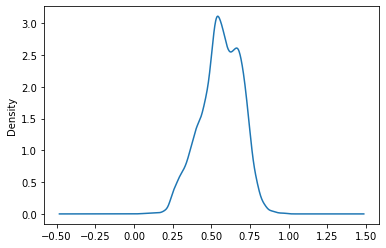

<IPython.core.display.Javascript object>

In [37]:
df[:35000].elevation.plot(kind="kde")

<AxesSubplot:ylabel='Density'>

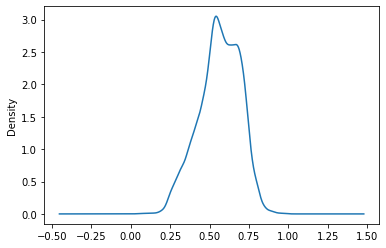

<IPython.core.display.Javascript object>

In [38]:
df[35000:70000].elevation.plot(kind="kde")

In [39]:
ranked_features[:-4]

['elevation',
 'horizontal_dist_to_roadways',
 'horizontal_dist_to_fire_points',
 'horizontal_dist_to_hydrology',
 'vertical_dist_to_hydrology',
 'aspect',
 'hillshade_noon',
 'hillshade_9am',
 'hillshade_3pm',
 'slope']

<IPython.core.display.Javascript object>

elevation


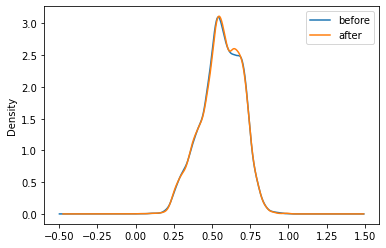

horizontal_dist_to_roadways


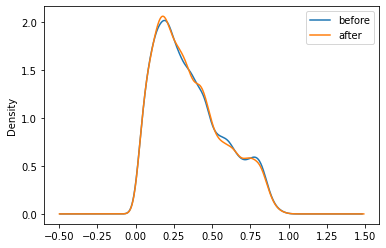

horizontal_dist_to_fire_points


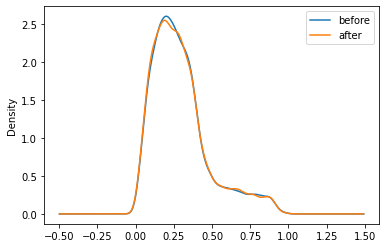

horizontal_dist_to_hydrology


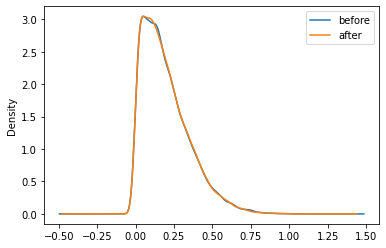

vertical_dist_to_hydrology


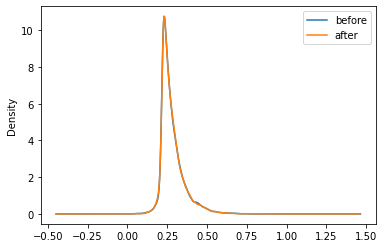

aspect


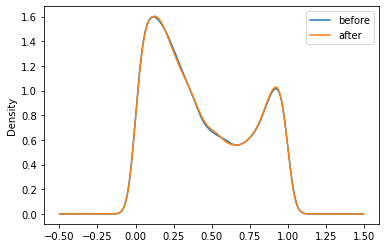

hillshade_noon


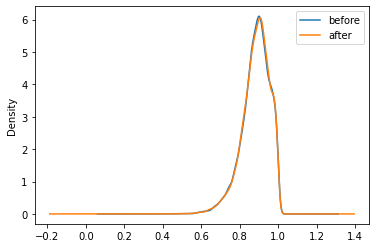

hillshade_9am


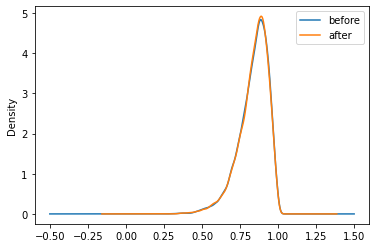

hillshade_3pm


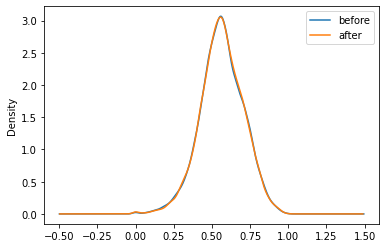

slope


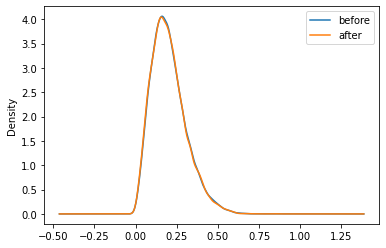

<IPython.core.display.Javascript object>

In [60]:
# check continuous features before and after
for feature in ranked_features[:-4]:
    print(feature)
    pd.DataFrame(
        zip(df[100000:123785][feature], df[123785 : 123785 + 23785][feature]),
        columns=["before", "after"],
    ).plot(kind="kde")
    plt.show()

In [61]:
pd.DataFrame(
    zip(df[100000:123785]["cover_type"], df[123785 : 123785 + 23785]["cover_type"]),
    columns=["before", "after"],
).before.value_counts()

1.0    13644
0.0    10141
Name: before, dtype: int64

<IPython.core.display.Javascript object>

In [62]:
pd.DataFrame(
    zip(df[100000:123785]["cover_type"], df[123785 : 123785 + 23785]["cover_type"]),
    columns=["before", "after"],
).after.value_counts()

1.0    13612
0.0    10173
Name: after, dtype: int64

<IPython.core.display.Javascript object>

In [54]:
pd.DataFrame(
    zip(df[:35000]["cover_type"], df[35000:70000]["cover_type"]),
    columns=["before", "after"],
).melt().groupby("variable").sum()

,value
variable,
after,19932.0
before,20019.0


<IPython.core.display.Javascript object>

In [95]:
pd.DataFrame(
    zip(df[:35000]["cover_type"], df[35000:70000]["cover_type"]),
    columns=["before", "after"],
).melt().plot()

,variable,value
0,before,1.0
1,before,1.0
2,before,0.0
3,before,1.0
4,before,1.0
...,...,...
69995,after,1.0
69996,after,1.0
69997,after,0.0
69998,after,0.0


<IPython.core.display.Javascript object>

<AxesSubplot:>

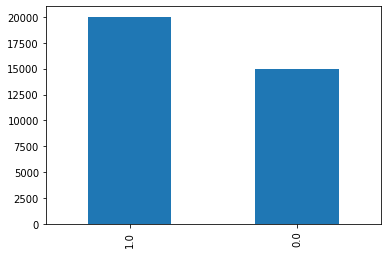

<IPython.core.display.Javascript object>

In [87]:
pd.DataFrame(
    zip(df[:35000]["cover_type"], df[35000:70000]["cover_type"]),
    columns=["before", "after"],
).before.value_counts().plot(kind="bar")

<AxesSubplot:>

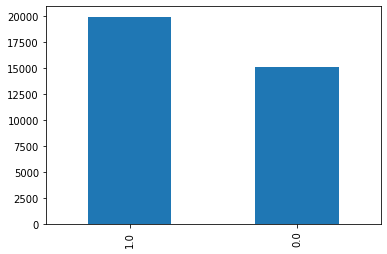

<IPython.core.display.Javascript object>

In [90]:
pd.DataFrame(
    zip(df[:35000]["cover_type"], df[35000:70000]["cover_type"]),
    columns=["before", "after"],
).after.value_counts().plot(kind="bar")

In [80]:
11356 + 8663

20019

<IPython.core.display.Javascript object>

In [81]:
8576 + 6405

14981

<IPython.core.display.Javascript object>

In [69]:
pd.DataFrame(zip(df[:35000]["cover_type"], df[35000:70000]["cover_type"]))

,0,1
0,1.0,0.0
1,1.0,1.0
2,0.0,1.0
3,1.0,0.0
4,1.0,0.0
...,...,...
34995,0.0,1.0
34996,0.0,1.0
34997,1.0,0.0
34998,1.0,0.0


<IPython.core.display.Javascript object>

In [72]:
pd.DataFrame(
    zip(df[:35000]["cover_type"], df[35000:70000]["cover_type"])
).value_counts()

0    1  
1.0  1.0    11356
     0.0     8663
0.0  1.0     8576
     0.0     6405
dtype: int64

<IPython.core.display.Javascript object>

In [ ]:
catcols

In [49]:
feature

NameError: name 'feature' is not defined

<IPython.core.display.Javascript object>

In [52]:
list(catcols)

[]

<IPython.core.display.Javascript object>

In [30]:
df[:35000]

,elevation,aspect,slope,horizontal_dist_to_hydrology,vertical_dist_to_hydrology,horizontal_dist_to_roadways,hillshade_9am,hillshade_noon,hillshade_3pm,horizontal_dist_to_fire_points,wilderness_area_1,wilderness_area_2,wilderness_area_3,wilderness_area_4,cover_type
426349,0.449482,0.952778,0.227273,0.136006,0.227390,0.098356,0.740157,0.850394,0.653543,0.164645,0.0,0.0,1.0,0.0,1.0
81549,0.516192,0.483333,0.212121,0.130279,0.258398,0.644935,0.893701,0.968504,0.582677,0.371532,1.0,0.0,0.0,0.0,1.0
429494,0.672927,0.127778,0.424242,0.416607,0.242894,0.114093,0.850394,0.661417,0.279528,0.234351,0.0,1.0,0.0,0.0,0.0
321330,0.706606,0.341667,0.181818,0.473157,0.260982,0.425741,0.944882,0.909449,0.472441,0.421581,0.0,0.0,1.0,0.0,1.0
183784,0.570596,0.066667,0.121212,0.380100,0.279070,0.169594,0.850394,0.874016,0.562992,0.327199,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
361424,0.595207,0.791667,0.212121,0.088762,0.255814,0.185612,0.712598,0.940945,0.779528,0.360100,0.0,0.0,1.0,0.0,0.0
470416,0.678109,0.411111,0.060606,0.060845,0.233850,0.594914,0.889764,0.940945,0.582677,0.119615,0.0,0.0,1.0,0.0,0.0
229018,0.101036,0.877778,0.257576,0.137437,0.325581,0.038921,0.685039,0.881890,0.744094,0.086156,0.0,0.0,0.0,1.0,1.0
428123,0.761658,0.708333,0.303030,0.756621,0.635659,0.492202,0.673228,0.976378,0.838583,0.373066,0.0,0.0,1.0,0.0,1.0


<IPython.core.display.Javascript object>

### 3. Separate dataset by chunks + shuffle feature values

Let's induce 3 ChangePoints in the dataset, resulting in 4 different, sequential concepts.
1. Original data distribution - no induced drift
2. Rotate values for top 4 most important features
3. Rotate values for middle 6 features ranked by importance
4. Rotate values for bottom 4 least important features


In [25]:
import copy
import random

<IPython.core.display.Javascript object>

In [ ]:
# chunk_to_feature_rank_strategy = {0: None, 1: (0, 4), 2: (4, 10), 3: (10, 14)} # most to least severe
chunk_to_feature_rank_strategy = {0: None, 1: (10, 14), 2: (4, 10), 3: (0, 4)} # least to most severe

def induce_drift(df, ranked_features, strategy):
    
    df = df.reset_index(drop=True)

    chunk_size = int(df.shape[0] / 4)
    change_points = list(range(0, len(df) - chunk_size, chunk_size))
    df_chunks = [df[i : i + chunk_size] for i in change_points]
    
    random.seed(42)
    shuffled_df_chunks = []

    for i, df_chunk in enumerate(df_chunks):

        # lookup feature rotation strategy
        strategy = chunk_to_feature_rank_strategy[i]

        if strategy:
            features_to_rotate = ranked_features[strategy[0] : strategy[1]]

            # get shuffled col_names to ensure all fields have actually changed index
            col_names = df_chunk[features_to_rotate].columns.tolist()
            shuffled_col_names = copy.deepcopy(col_names)

            while any(col_names[j] == shuffled_col_names[j] for j in range(len(col_names))):
                random.shuffle(shuffled_col_names)

            # rename columns with shuffled names
            shuffle_col_map = {
                col_names[k]: shuffled_col_names[k] for k in range(len(col_names))
            }
            shuffled_df_chunk = df_chunk.rename(columns=shuffle_col_map)

            shuffled_df_chunks.append(shuffled_df_chunk[df.columns.values])

        else:
            shuffled_df_chunks.append(df_chunk)

    return pd.concat(shuffled_df_chunks, axis=0), change_points


In [ ]:
%%time

drift_df, change_points = induce_drift(
    df, ranked_features, chunk_to_feature_rank_strategy
)

In [27]:
# with open("../data/covtype_induced_drift.pkl", "wb") as f:
#     pickle.dump((drift_df, change_points), f)

# with open("../data/covtype_induced_drift.pkl", "rb") as f:
#     drift_df, change_points = pickle.load(f)

<IPython.core.display.Javascript object>

In [26]:
df

,elevation,aspect,slope,horizontal_dist_to_hydrology,vertical_dist_to_hydrology,horizontal_dist_to_roadways,hillshade_9am,hillshade_noon,hillshade_3pm,horizontal_dist_to_fire_points,wilderness_area_1,wilderness_area_2,wilderness_area_3,wilderness_area_4,cover_type
426349,0.449482,0.952778,0.227273,0.136006,0.227390,0.098356,0.740157,0.850394,0.653543,0.164645,0.0,0.0,1.0,0.0,1.0
81549,0.516192,0.483333,0.212121,0.130279,0.258398,0.644935,0.893701,0.968504,0.582677,0.371532,1.0,0.0,0.0,0.0,1.0
429494,0.672927,0.127778,0.424242,0.416607,0.242894,0.114093,0.850394,0.661417,0.279528,0.234351,0.0,1.0,0.0,0.0,0.0
321330,0.706606,0.341667,0.181818,0.473157,0.260982,0.425741,0.944882,0.909449,0.472441,0.421581,0.0,0.0,1.0,0.0,1.0
183784,0.570596,0.066667,0.121212,0.380100,0.279070,0.169594,0.850394,0.874016,0.562992,0.327199,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259178,0.531736,0.777778,0.136364,0.107373,0.266150,0.376985,0.763780,0.948819,0.736220,0.065523,0.0,0.0,1.0,0.0,1.0
365838,0.587435,0.677778,0.242424,0.085898,0.248062,0.439652,0.732283,0.988189,0.791339,0.121428,0.0,0.0,1.0,0.0,1.0
131932,0.646373,0.011111,0.136364,0.202577,0.298450,0.706758,0.818898,0.874016,0.594488,0.062178,1.0,0.0,0.0,0.0,1.0
146867,0.516192,0.244444,0.181818,0.021475,0.227390,0.509344,0.937008,0.866142,0.433071,0.370277,1.0,0.0,0.0,0.0,1.0


<IPython.core.display.Javascript object>

https://stats.stackexchange.com/questions/46429/transform-data-to-desired-mean-and-standard-deviation

In [27]:
test = [2,4,6,3,2,5,6,7,7, 3,5,1,7,7]

<IPython.core.display.Javascript object>

In [ ]:
m1 = np.mean(test)
s1 = np.std(test)



In [31]:
np.mean(test)

4.642857142857143

<IPython.core.display.Javascript object>

### Induce drift forward chain

In [29]:
chunk_to_feature_rank_strategy = {0: None, 1: (0, 4), 2: (4, 10), 3: (10, 14)} # most to least severe
# chunk_to_feature_rank_strategy = {0: None, 1: (10, 14), 2: (4, 10), 3: (0, 4)} # least to most severe

def induce_drift_forward(df, ranked_features, rotation_strategy):
    
    df = df.reset_index(drop=True)

    chunk_size = int(df.shape[0] / 4)
    change_points = list(range(0, len(df) - chunk_size, chunk_size))
    chunk_end_idxs = [i + chunk_size for i in change_points]

    drift_df = copy.deepcopy(df)
    
    for i, change_point in enumerate(change_points):

        # lookup feature rotation strategy
        strategy = rotation_strategy[i]

        if strategy:

            # grab records that need to be rotated - chained foward
            working_df = copy.deepcopy(drift_df[change_point:])

            features_to_rotate = ranked_features[strategy[0] : strategy[1]]

            # get shuffled col_names to ensure all fields have actually changed index
            col_names = working_df[features_to_rotate].columns.tolist()
            shuffled_col_names = copy.deepcopy(col_names)

            while any(col_names[j] == shuffled_col_names[j] for j in range(len(col_names))):
                random.shuffle(shuffled_col_names)

            # rename columns with shuffled names
            shuffle_col_map = {
                col_names[k]: shuffled_col_names[k] for k in range(len(col_names))
            }
            shuffled_working_df = working_df.rename(columns=shuffle_col_map)

            # update drift_df to overwrite the new records from working df
            drift_df = drift_df.iloc[:change_point]
            drift_df = drift_df.append(shuffled_working_df)

    return drift_df, change_points
   


<IPython.core.display.Javascript object>

In [30]:
%%time

drift_df, change_points = induce_drift_forward(
    df, ranked_features, chunk_to_feature_rank_strategy
)

CPU times: user 171 ms, sys: 86 ms, total: 257 ms
Wall time: 262 ms


<IPython.core.display.Javascript object>

In [31]:
with open("../data/covtype_induced_drift_forward_norm_reverse.pkl", "wb") as f:
    pickle.dump((drift_df, change_points), f)

# with open("../data/covtype_induced_drift_forward_norm.pkl", "rb") as f:
#     drift_df, change_points = pickle.load(f)

<IPython.core.display.Javascript object>

### Are targets distributed evenly among concepts?

In [31]:
drift_df.iloc[: change_points[1]].cover_type.value_counts()

1.0    70733
0.0    53052
Name: cover_type, dtype: int64

<IPython.core.display.Javascript object>

In [32]:
drift_df.iloc[change_points[1] : change_points[2]].cover_type.value_counts()

1.0    71095
0.0    52690
Name: cover_type, dtype: int64

<IPython.core.display.Javascript object>

In [33]:
drift_df.iloc[change_points[2] : change_points[3]].cover_type.value_counts()

1.0    70728
0.0    53057
Name: cover_type, dtype: int64

<IPython.core.display.Javascript object>

In [34]:
drift_df.iloc[change_points[3] :].cover_type.value_counts()

1.0    70745
0.0    53041
Name: cover_type, dtype: int64

<IPython.core.display.Javascript object>

## Does this dataset have drift?

In [35]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from test_harness.utils.utils import (
    plot_experiment_error,
    plot_multiple_experiments,
    plot_response_distributions_bysplit,
    aggregate_experiment_metrics,
)

from test_harness.datasets.dataset import Dataset
from test_harness.experiments.baseline_experiment import BaselineExperiment
from test_harness.experiments.topline_experiment import ToplineExperiment
from test_harness.experiments.sqsi_experiment import SQSI_MRExperiment

<IPython.core.display.Javascript object>

In [36]:
# specify columns and if categorical - to delete
col_names = [
    ("elevation", False),
    ("aspect", False),
    ("slope", False),
    ("horizontal_dist_to_hydrology", False),
    ("vertical_dist_to_hydrology", False),
    ("horizontal_dist_to_roadways", False),
    ("hillshade_9am", False),
    ("hillshade_noon", False),
    ("hillshade_3pm", False),
    ("horizontal_dist_to_fire_points", False),
]
wilderness_area_cols = [(f"wilderness_area_{i+1}", True) for i in range(4)]
col_names = col_names + wilderness_area_cols + [("cover_type", True)]

<IPython.core.display.Javascript object>

In [37]:
column_mapping = {
    "target": "cover_type",
    "numerical_features": [col for col, iscat in col_names if not iscat],
    "categorical_features": [col for col, iscat in col_names if iscat][:-1],
}

CT_dataset = Dataset(full_df=df, column_mapping=column_mapping, window_size=17500 * 2)

model = RandomForestClassifier(n_estimators=10, random_state=42, max_depth=5)
param_grid = {"clf__n_estimators": [3, 5, 10], "clf__max_depth": [3, 5, 10]}

<IPython.core.display.Javascript object>

In [38]:
%%time

baseline = BaselineExperiment(model=model, dataset=CT_dataset, param_grid=param_grid)
baseline.run()

topline = ToplineExperiment(model=model, dataset=CT_dataset, param_grid=param_grid)
topline.run()

CPU times: user 20.4 s, sys: 478 ms, total: 20.9 s
Wall time: 39.4 s


<IPython.core.display.Javascript object>

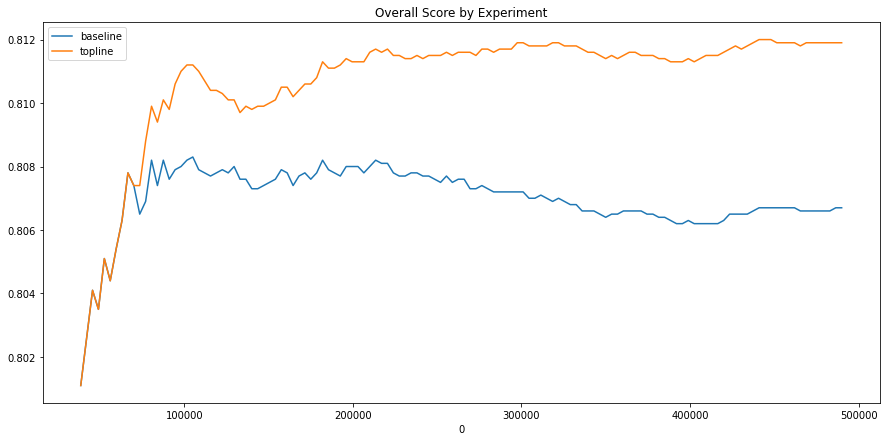

,times_retrained,percent_total_labels,total_train_time
experiment,,,
baseline,1,0.0707,0.29
topline,14,0.9896,4.37


<IPython.core.display.Javascript object>

In [39]:
exps = [baseline, topline]
plot_multiple_experiments(exps, change_points=False)
aggregate_experiment_metrics(exps)